In [1]:
import re
import os
import glob
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
 

In [9]:
def sort_dirs(path):
    path = os.path.basename(path)
    if path.startswith("."):
        return 0
    found = re.search(r'\((\d+)\)', path)
    if not found:
        return 0
    return int(found.group(1))

def sort_prod(file):
    if file.startswith("."):
        return 0
    try:
        found = re.search(r'2022-\d{2}-\d{2}', file)
        index = found.end()
    except Exception as e:
        print(f"ERR on {file}")
    return int(file[index - 2:file.index(".csv")])
    
def split_time_day(df):
    df[['time','day']] = (
        df['time_day']
           .str.split('/', expand=True)
           .apply(lambda col: col.str.strip())
    )
    df['day'] = df['day'].astype(int)
    df.drop('time_day', axis=1, inplace=True)
    return df

def parse_conditions(dir):
    path = os.path.join(os.getcwd(), dir)
    # Get diagram 1 data into a dataframe
    full_path = os.path.join(path, "Weather_Diagram_1*")
    diagram_1_data = []
    for file in sorted(glob.glob(full_path), key=sort_dirs):
        if file.startswith("."):
            continue
        data = pd.read_csv(file, sep=";",skiprows=1,header=None,
                           names=["time_day","ambient","module_temp","wind"])
        diagram_1_data.append(data)
    df1 = pd.concat(diagram_1_data, ignore_index=True)
    df1 = split_time_day(df1)
    
    # Get diagram 2 data into a dataframe
    full_path = os.path.join(path, "Weather_Diagram_2*")
    diagram_2_data = []
    for file in sorted(glob.glob(full_path), key=sort_dirs):
        if file.startswith("."):
            continue
        data = pd.read_csv(file, sep=";",skiprows=1,header=None,
                           names=["time_day","insolation"])
        diagram_2_data.append(data)
    df2 = pd.concat(diagram_2_data, ignore_index=True)
    df2 = split_time_day(df2)
    
    # Merge into one dataframe
    combined_df = pd.merge(df1,df2,on=['day','time'])
    return combined_df
    
def parse_production(dir):
    path = os.path.join(os.getcwd(), dir)
    df = []
    for file in sorted(os.listdir(path),key=sort_prod):
        if file.startswith("."):
            continue
        full_path = f"{path}/{file}"
        data = pd.read_csv(full_path, sep=";",skiprows=1,header=None, 
                           names=["time","power"])
        day = int(file.split("-")[-1].split(".")[0])
        data['day'] = day
        df.append(data)
    df = pd.concat(df, ignore_index=True)
    df['time'] = df['time'].str.strip()
    df['power'] = pd.to_numeric(df['power'], errors='coerce')
    return df
    
    
        
# Load data
data_dir = "PVSystem/"

all_inputs = []
all_outputs = []
by_month_data = dict()
for dir in sorted(os.listdir(data_dir)):
    full_path = os.path.join(data_dir, dir)
    if not os.path.isdir(full_path) or dir.startswith("."):
        continue
    cond_df = parse_conditions(full_path + '/Conditions')
    prod_df = parse_production(full_path + '/Production')
    all_inputs.append(cond_df.assign(month=dir))
    all_outputs.append(prod_df.assign(month=dir))
    
    by_month_data[dir] = dict()
    by_month_data[dir]['cond'] = []
    by_month_data[dir]['prod'] = []
    by_month_data[dir]['cond'].append(cond_df.assign(month=dir))
    by_month_data[dir]['prod'].append(prod_df.assign(month=dir))

all_inputs = pd.concat(all_inputs, ignore_index=True)
all_outputs = pd.concat(all_outputs, ignore_index=True)
all_data = pd.merge(
    all_inputs,
    all_outputs,
    on=['month','day','time'],
    how='left'
)


In [10]:
# Create and train model
all_data['hour'] = all_data['time'].str.extract(r'(\d+):').astype(int)
features = ['ambient', 'module_temp', 'wind', 'insolation', 'month', 'day', 'hour']
target = ['power']

data = all_data[features + target].dropna().reset_index(drop=True)

scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(data[features])
Y_scaled = scaler_Y.fit_transform(data[target])

SEQ_LEN = 12
def create_sequences(X, Y, seq_len):
    Xs, Ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        Ys.append(Y[i+seq_len])
    return np.array(Xs), np.array(Ys)

X_seq, y_seq = create_sequences(X_scaled, Y_scaled, SEQ_LEN)
X_train, X_val, Y_train, Y_val = train_test_split(X_seq, y_seq, test_size=0.2,
                                                  random_state=42,shuffle=False)

tf.random.set_seed(42)
model_name = "power_prediction_model.keras"
if not os.path.isfile(os.path.join(os.getcwd(),model_name)):
    model = Sequential([
        Input(shape=(SEQ_LEN, X_seq.shape[2])),
        LSTM(64, recurrent_activation='sigmoid',activation='tanh',return_sequences=True),
        Dropout(0.2),
        LSTM(32, recurrent_activation='sigmoid',activation='tanh'),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', 
                  loss='mse',
                  metrics=['mse']        
    )
    log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    earlystopping_callback = EarlyStopping(patience=20, restore_best_weights=True)

    history = model.fit(
        X_train, Y_train,
        validation_data=(X_val, Y_val),
        epochs=500,
        batch_size=64,
        callbacks=[earlystopping_callback, tensorboard_callback],
    )

    model.evaluate(X_val, Y_val)
    # model.save("power_prediction_model.keras")

Epoch 1/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0751 - mse: 0.0751 - val_loss: 0.0899 - val_mse: 0.0899
Epoch 2/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0408 - mse: 0.0408 - val_loss: 0.0816 - val_mse: 0.0816
Epoch 3/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0301 - mse: 0.0301 - val_loss: 0.0356 - val_mse: 0.0356
Epoch 4/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0259 - mse: 0.0259 - val_loss: 0.0288 - val_mse: 0.0288
Epoch 5/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 6/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0249 - mse: 0.0249 - val_loss: 0.0223 - val_mse: 0.0223
Epoch 7/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0192 - val_mse: 0.0192
Epoch 8/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0180 - val_mse: 0.0180
Epoch 9/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.02

In [4]:
avg = []
for xi,xp, y in zip(X_val, model(X_val), Y_val):
    err = (1 - (abs((xp - y)))) * 100
    avg.append(err)
print(f"Avg acc: {np.mean(avg)}")

Avg acc: 91.201904296875


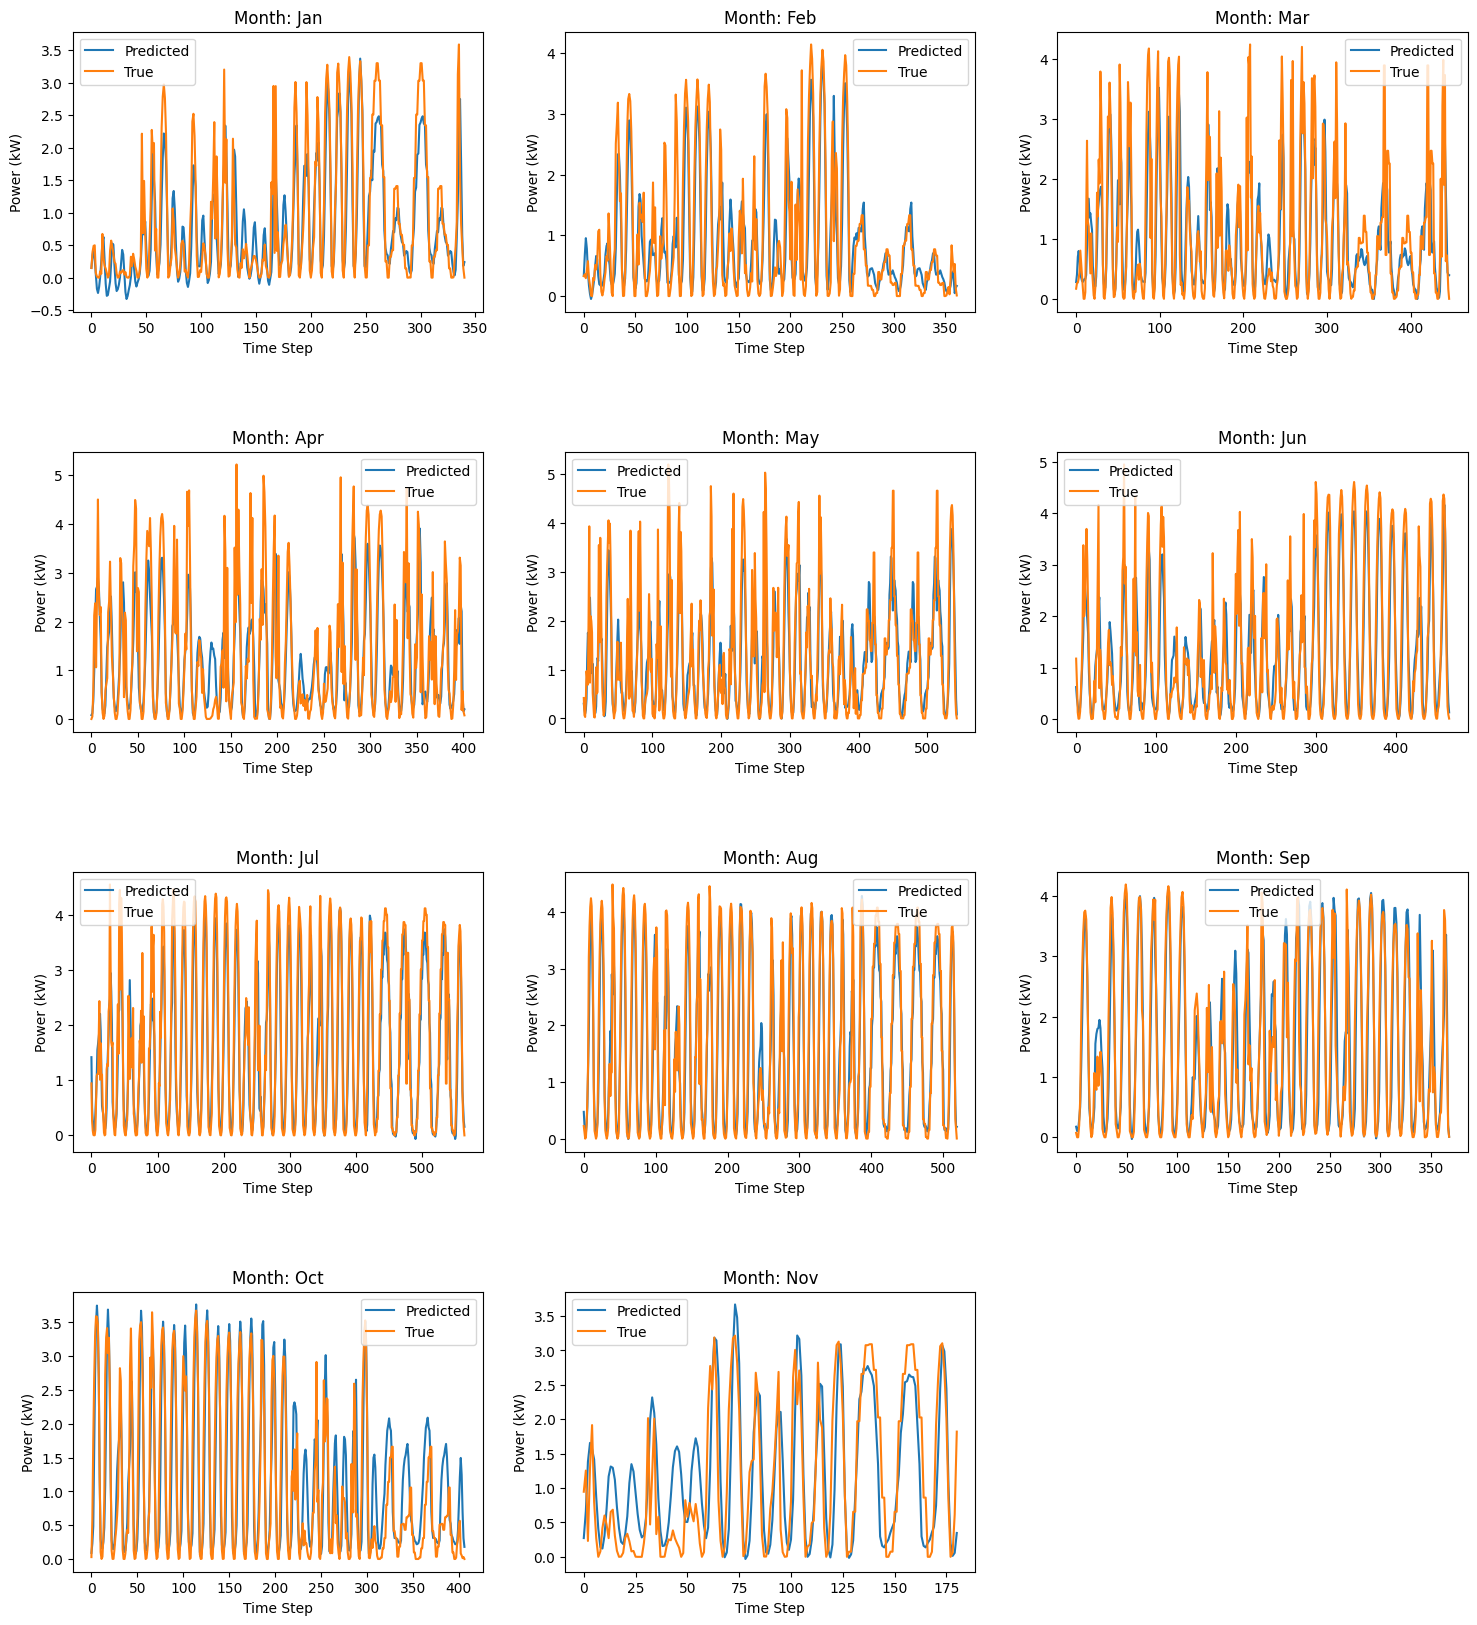

In [11]:
month = {
    "01": "Jan",
    "02": "Feb",
    "03": "Mar",
    "04": "Apr",
    "05": "May",
    "06": "Jun",
    "07": "Jul",
    "08": "Aug",
    "09": "Sep",
    "10": "Oct",
    "11": "Nov",
    "12": "Dec"
}

num_months = len(by_month_data)
cols = 3
rows = math.ceil(num_months / cols)
fig, axs = plt.subplots(rows, cols, figsize=(18, 5 * rows))
plt.subplots_adjust(hspace=0.5)
axs = axs.flatten()
idx = 0

for key in by_month_data:
    input_df, output_df = by_month_data[key]['cond'][0], by_month_data[key]['prod'][0]
    all_data = pd.merge(input_df, output_df, on=['month','day','time'], how='left')
    all_data['hour']   = all_data['time'].str.extract(r'(\d+):').astype(int)

    data = all_data[features + target].dropna().reset_index(drop=True)
    X_scaled = scaler_X.transform(data[features])
    Y_scaled = scaler_Y.transform(data[target])

    X_seq, Y_seq = create_sequences(X_scaled, Y_scaled, SEQ_LEN)
    Y_pred_scaled = model(X_seq)
    pred_unscaled = scaler_Y.inverse_transform(Y_pred_scaled).flatten()
    true_unscaled = scaler_Y.inverse_transform(Y_seq).flatten()

    ax = axs[idx]
    ax.plot(pred_unscaled, label="Predicted")
    ax.plot(true_unscaled, label="True")
    ax.set_title(f"Month: {month[key]}")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Power (kW)")
    ax.legend()

    idx += 1
    
for j in range(idx, len(axs)):
    axs[j].axis('off')

plt.show()